<center> <img src = https://moneypapa.ru/wp-content/uploads/2016/12/moneypapa.ru-%D0%BA%D0%B0%D0%BA-%D0%B2%D1%8B%D0%B1%D1%80%D0%B0%D1%82%D1%8C-%D0%B4%D0%B5%D0%BF%D0%BE%D0%B7%D0%B8%D1%82-fb.jpg alt="drawing" style="width:600px;">

# <center> Проект: прогнозирование открытия вклада клиентом банка </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

# %matplotlib inline
plt.style.use('seaborn')

## <center>  Часть 1. Знакомство с данными, обработка пропусков и выбросов </center>

### 1.1 Чтение данных

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
display(df.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


**Данные о клиентах банка:**
* *age* (возраст);
* *job* (сфера занятости);
* *marital* (семейное положение);
* *education* (уровень образования);
* *default* (имеется ли просроченный кредит);
* *housing* (имеется ли кредит на жильё);
* *loan* (имеется ли кредит на личные нужды);
* *balance* (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**
* *contact* (тип контакта с клиентом);
* *month* (месяц, в котором был последний контакт);
* *day* (день, в который был последний контакт);
* *duration* (продолжительность контакта в секундах).

**Прочие признаки:**
- *campaign* (количество контактов с этим клиентом в течение текущей кампании);
- *pdays* (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- *previous* (количество контактов до текущей кампании)
- *poutcome* (результат прошлой маркетинговой кампании).  


*deposit* **целевая переменная**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### 1.2 Определение пропусков

In [3]:
# определяем явные пропуски
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В признаке balance есть 25 пропусков

In [4]:
# определяем неявные пропуски
display(df['job'].value_counts())
display(df['education'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

В 70 строках признака job присутствует значение 'unknown'  
В 497 строках признака unknown присутствует значение 'unknown'

### 1.3 Преобразуем признак **balance** таким образом, чтобы он корректно считывался, как вещественное число (float)

In [5]:
def get_balance(balance):
    """Убирает лишние символы в str и возвращает float.

    Args:
        balance (str): Строка, содержащая информацию суммы в долларах.

    Returns:
        float: Сумма баланса
    """
    if balance is np.nan: # пропуски оставляем без изменений
        return 
    num = balance.replace(' ', '') # убираем лишние пробелы
    if num[0] == '0': 
        return float(num[:-1]) # у нулевых значений баланса убираем знак доллара
    else:
        return float(num[:-4]) # у остальных значений убираем знак доллара, два ноля, запятую

In [6]:
# применим функцию и преобразуем признак
df['balance'] = df['balance'].apply(get_balance)

### 1.4 Обработаем пропуски в признаке **balance**, заменив их на медианные значения по данному признаку

In [8]:
df['balance'].fillna(df['balance'].median(), axis=0, inplace=True)

In [85]:
# 2 способ
# df.loc[(df['balance'].isnull() == True), 'balance'] = df['balance'].median()

### 1.5 Обработаем пропуски в категориальных признаках: **job** и **education**, заменив их на модальные значения

In [9]:
# самое популярное значение в job
job_mode = df['job'].mode()[0]
# самое популярное значение в education
education_mode = df['education'].mode()[0]

# выполняем замену
df['job'] = df['job'].apply(lambda x: job_mode if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x=='unknown' else x)

### 1.6 Удалим все выбросы для признака **balance**

In [10]:
# посмотрим на статистику признака
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

Видим, что максимальное и минимальное значение сильно отличается от остального диапазона значений

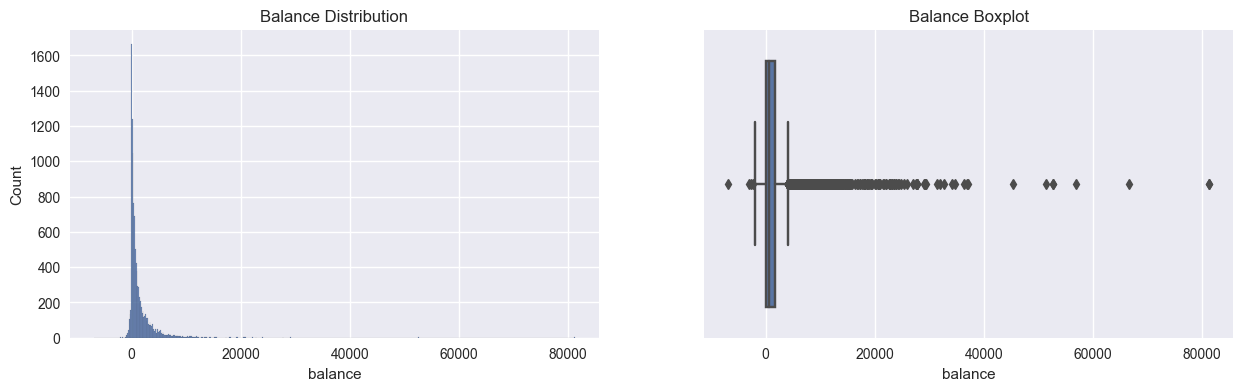

In [11]:
# построим гистограмму и коробчатую диаграмму для оценки распределения признака balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0])
histplot.set_title('Balance Distribution')
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1])
boxplot.set_title('Balance Boxplot');

Графики сильно заужены, это говорит о наличии выбросов в признаке **balance**. Избавимся от выбросов по методу межквартильного размаха

In [12]:
# функция для определения выбросов по методу Тьюки (межквартильного размаха)
def outliers_iqr(data, feature):
    """Вычисляет выбросы по формуле межквартильного размаха

    Args:
        data (DataFrame): DataFrame с исходными данными
        feature (Series): признак в DataFrame

    Returns:
        outliers (DataFrame): DataFrame с выбросами
        cleaned (DataFrame): DataFrame очищенный от выбросов
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    # print(round(lower_bound))
    upper_bound = quartile_3 + (iqr * 1.5)
    # print(round(upper_bound))
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [13]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


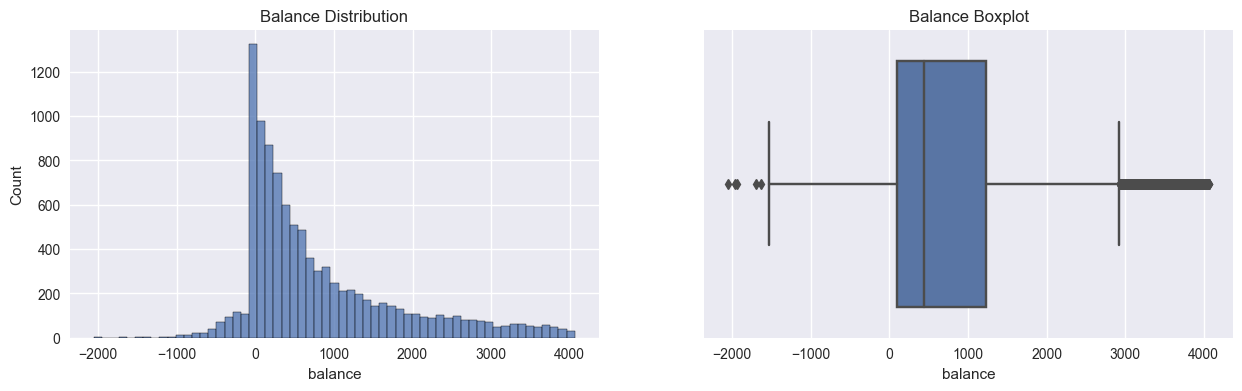

In [14]:
# построим визуализацию на очищенных данных
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

После очистки данных в признаке **balance** графики стали более читаемы, отчетливо видно распределение признака. Остаток на счетах клиентов банка в пределах от -1500$ до 3000$. Медиана около 500$ 

## <center> Часть 2:  Разведывательный анализ </center>

### 2.1 Изучим соотношение классов в целeвом признаке на предмет несбалансированности, проиллюстрируем результат

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

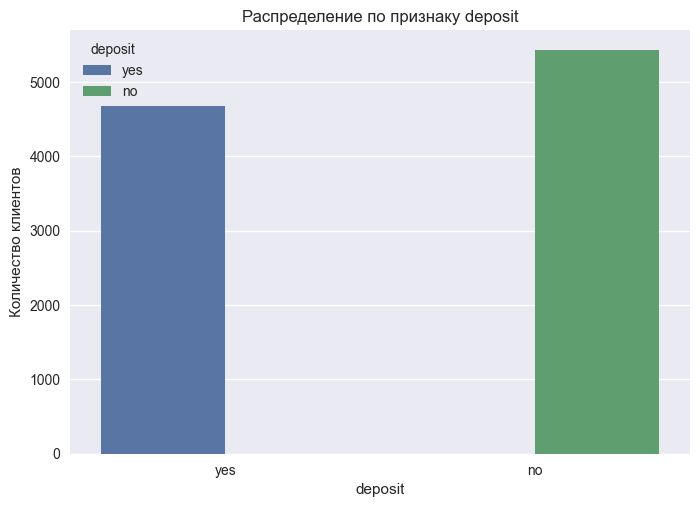

In [16]:
# долевое соотношение классов
display(cleaned['deposit'].value_counts(True))
# построим диаграмму соотношений значений в признаке
histplot = sns.countplot(data=cleaned, x='deposit', hue='deposit')
histplot.set_title("Распределение по признаку deposit")
histplot.set_ylabel('Количество клиентов');

### 2.2 Рассчитаем описательные статистики для количественных переменных

In [17]:
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Построим гистограммы и коробчатые диаграммы распределения каждого числового признака

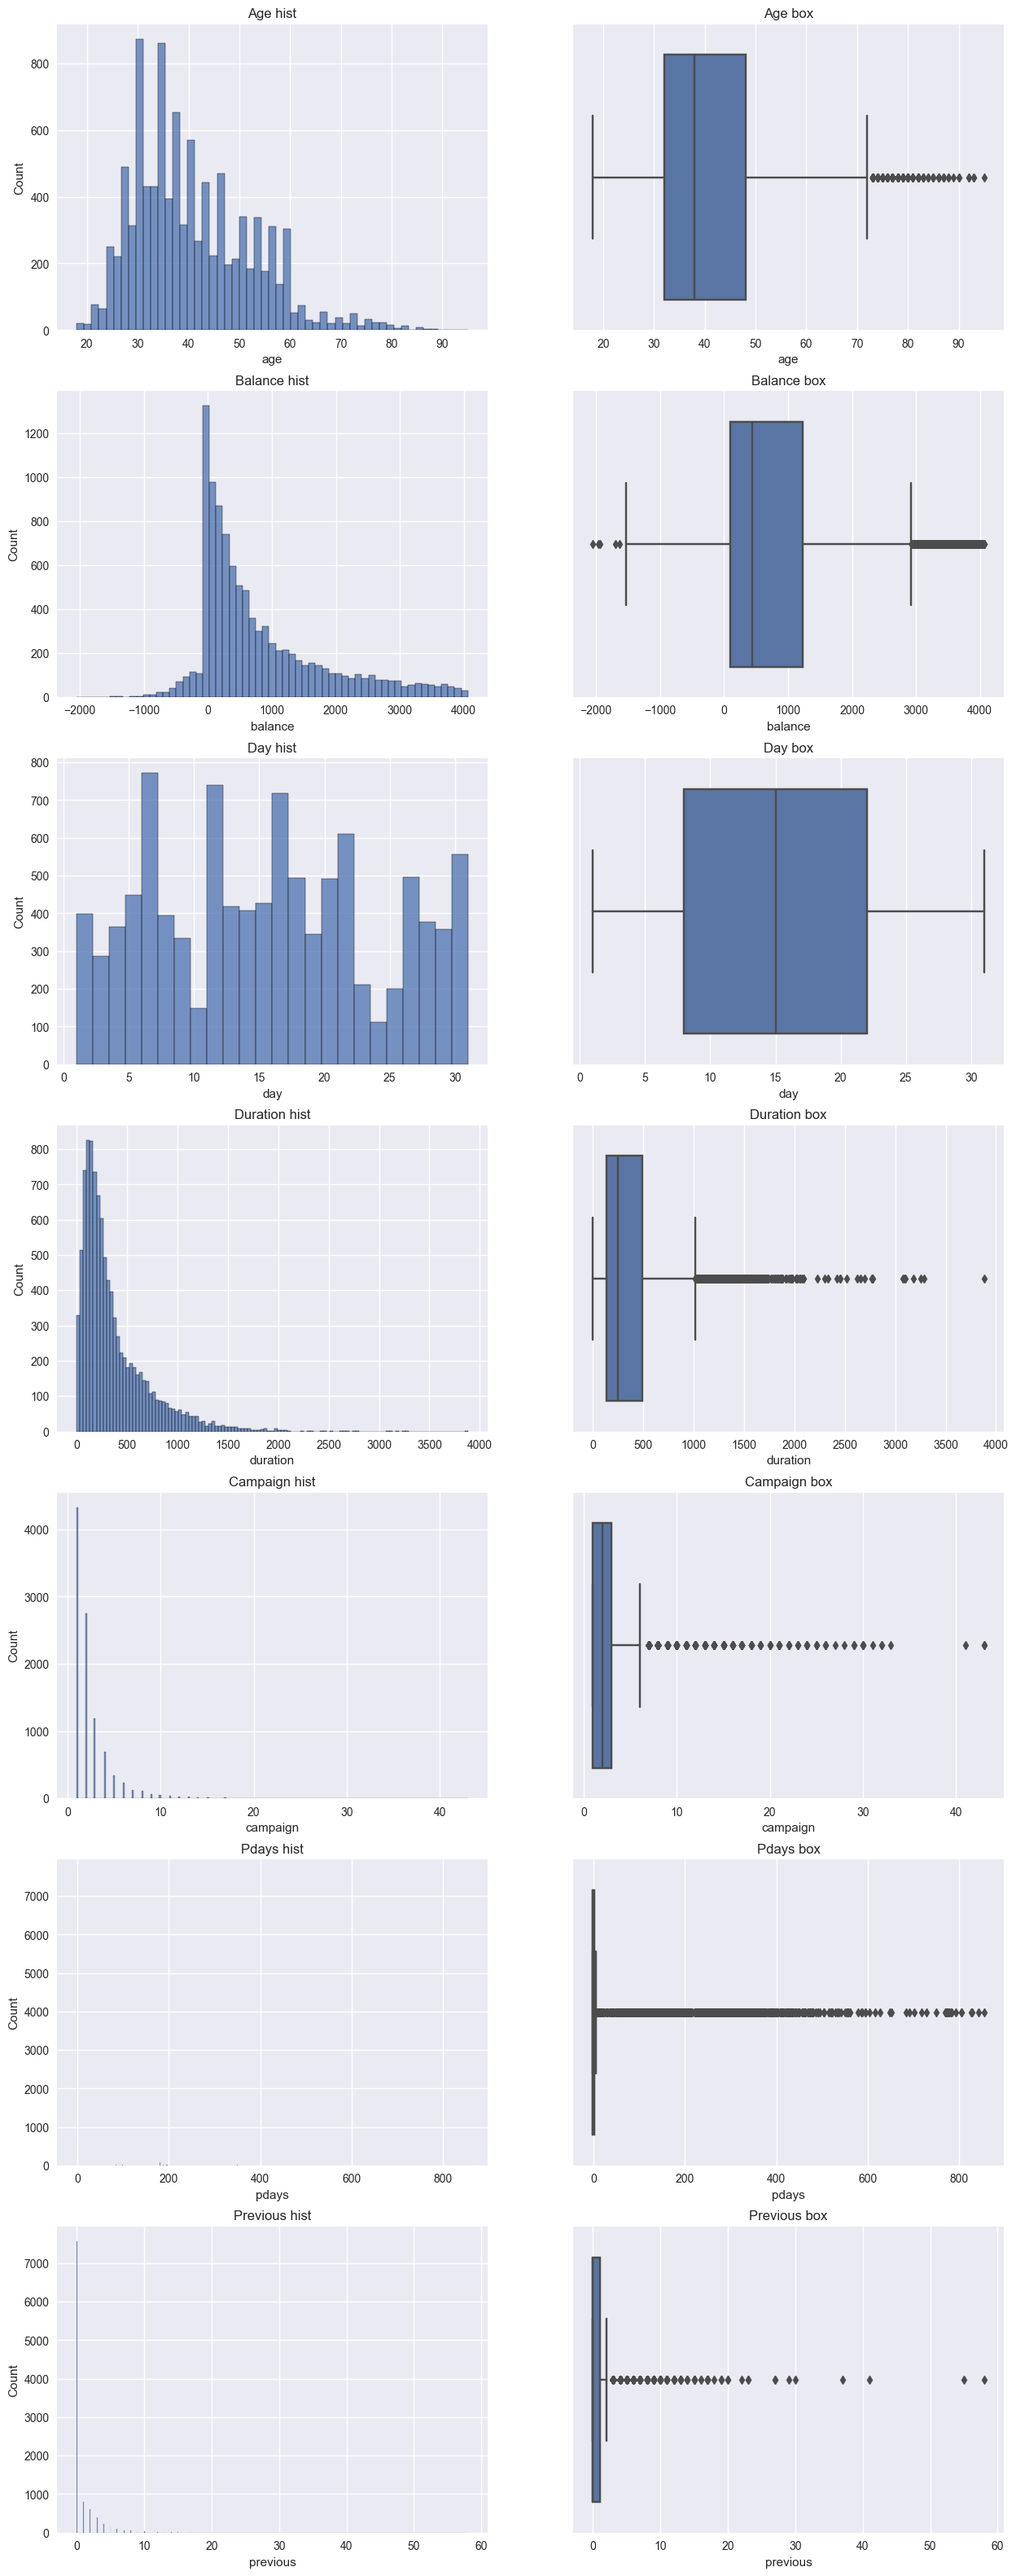

In [18]:
# создадим список с названиями числовых признаков
types = cleaned.dtypes
num_features = list(types[(types!='object')].index)
# строим визуализацию
n = len(num_features) # число признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40))
for i, feature in enumerate(num_features):
    num_histplot = sns.histplot(data=cleaned, x=feature, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist")
    num_boxplot = sns.boxplot(data=cleaned, x=feature, ax=axes[i][1])
    num_boxplot.set_title(f"{feature.title()} box")

* **age** (возраст). Возраст клиентов банка от 18 до 95 лет. Медиана 38 лет
* **balance** (баланс). Медиана 445$. Есть отрицательные значения баланса - имеется задолженность клиента перед банком.  
* **day** (день когда был последний контакт). Номер дня в месяце. Представлен различными значениями - позвонить могли в любой день месяца.
* **duration** (продолжительность контакта в секундах). Минимум 2 секунды - клиент сразу бросал трубку. Медиана - 252 секунды (около 4 минут). В редких случаях продолжительность составляет более 1500 секунд. Максимальное значение 3881 секунда - контакт длился более 1 часа.
* **campaign** (кол-во контактов с клиентом в текущей компании).  В большинстве случаев их не более 10. Максимальное значение 43.
* **pdays** (кол-во пропущенных дней с последней кампании до контакта в текущей кампании). График неинформативен, имеются выбросы.
* **previous** (кол-во контактов до текущей кампании). График неинформативен, имеются выбросы.

### 2.3 Рассчитаем описательные статистики для категориальных переменных

In [19]:
cleaned.describe(include='object').T

,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


Построим визуализации

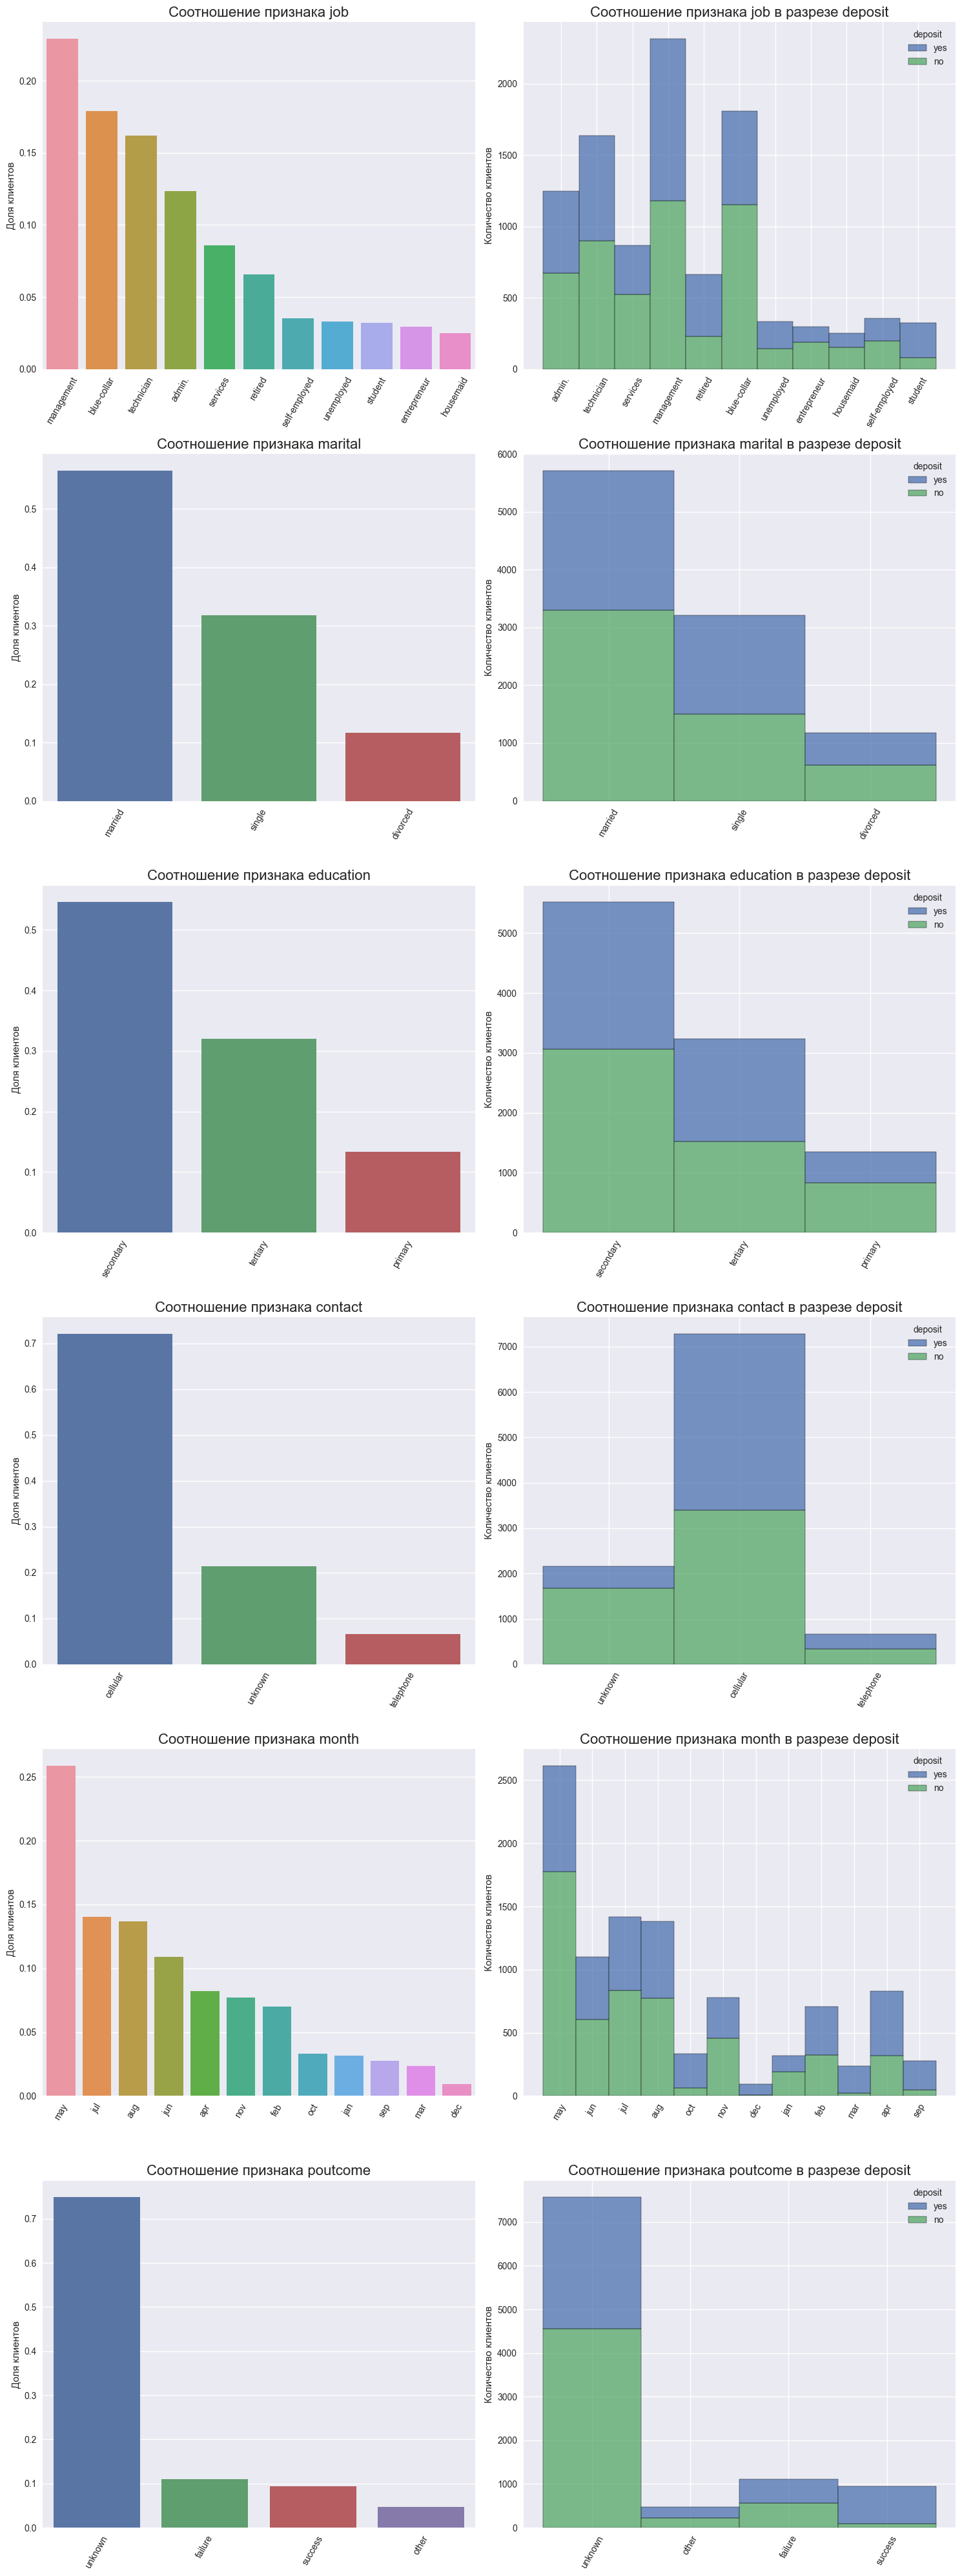

In [47]:
# список с категориальными признаками
cat_features = ['job',
 'marital',
 'education',
 'contact',
 'month',
 'poutcome']
n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 40))
#Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
for i, feature in enumerate(cat_features):
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.set_title(f'Соотношение признака {feature}', fontsize=16)
    count_barplot.set_xlabel('')
    count_barplot.set_ylabel('Доля клиентов')
    count_barplot.xaxis.set_tick_params(rotation=60)
    # строрим гистограмму в разрезе признака deposit
    barplot = sns.histplot(data=cleaned, x=feature, hue='deposit', multiple='stack', ax=axes[i][1])
    barplot.set_title(f'Соотношение признака {feature} в разрезе deposit', fontsize=16)
    barplot.set_xlabel('')
    barplot.set_ylabel('Количество клиентов')
    barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout() #выравнивание графиков

Всего представлено 11 сфер занятости. Маркетинговая компания проходила каждый месяц. Чаще всего встречается семейное положение merried, а образование secondary. Cамый большой процент неудач при взаимодействии в текущей маркетинговой кампании зафиксирован в мае.

### 2.4 Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже.

Создадим из признака age новый признак, в котором будет находиться индикатор принадлежности к одной из следующих категорий:
* <30
* 30-39
* 40-49
* 50-60
* 60+.

In [48]:
# создадим копию таблицы
df = cleaned.copy()
# список наименований интервалов
cut_labels = ['<30', '30-39', '40-49', '50-60', '60+']
# список границ интервалов
cut_bins = [0, 29, 39, 49, 60, 120]
# создаем признак
df['age'] = pd.cut(df['age'], bins=cut_bins, labels=cut_labels)

In [100]:
# 2 способ
# для удобства создадим признак с диапазонами возрастов
# def get_age(age):
#     if age < 30:
#         return '<30'
#     elif 30 <= age < 40:
#         return '30-39'
#     elif 40 <= age < 50:
#         return '40-49'
#     elif 50 <= age <= 60:
#         return '50-60'
#     else: 
#         return '60+'
# df['age'] = df['age'].apply(get_age)

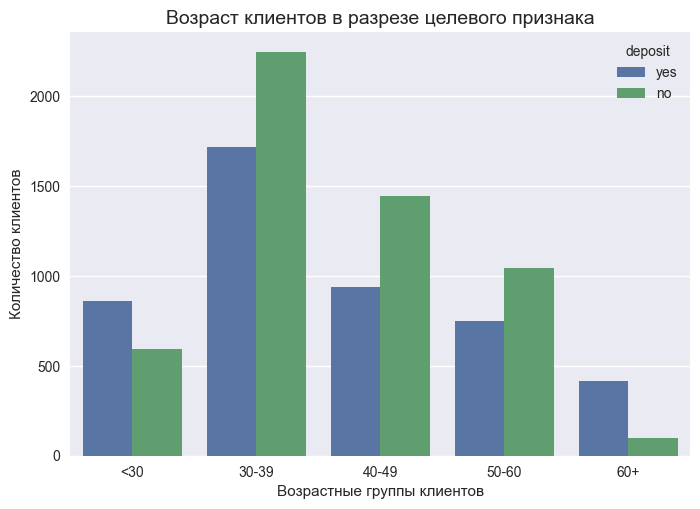

In [53]:
# построим столбчатую диаграмму
count_age = sns.countplot(data=df, x='age', hue='deposit')
count_age.set_title('Возраст клиентов в разрезе целевого признака', fontsize=14)
count_age.set_xlabel("Возрастные группы клиентов")
count_age.set_ylabel("Количество клиентов");

* Клиенты из групп <30 лет и 60+ лет более склонны открывать депозит, чем отказываться от открытия.
* Самая многочисленная возрастная группа клиентов банка 30-39 лет.
* Самая малочисленная возрастная группа клиентов банка 60+ лет.

### 2.5 Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

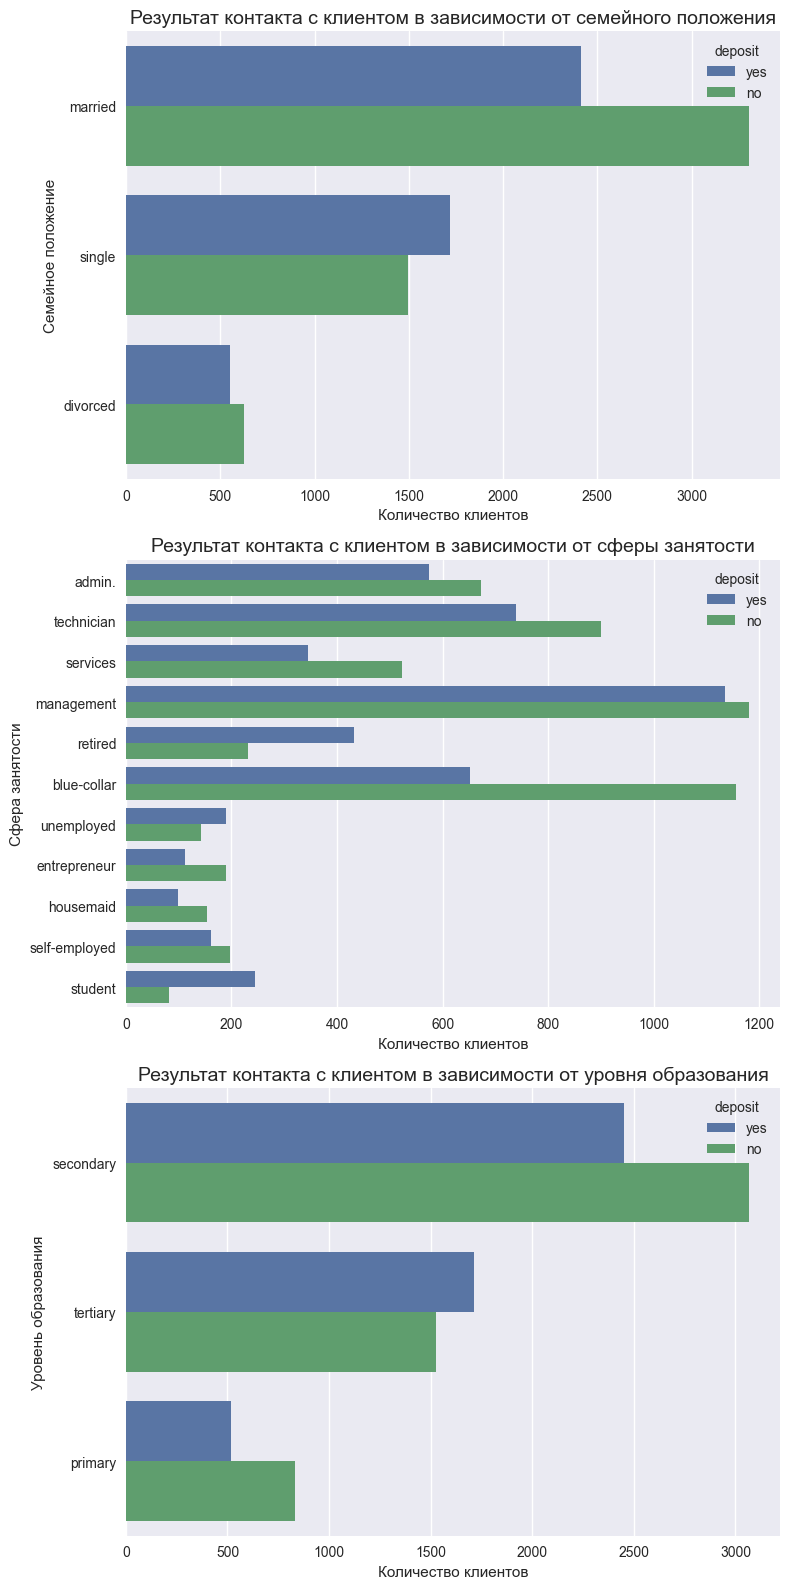

In [55]:
# построим столбчатую диаграмму
fig, axes = plt.subplots(3, figsize=(8, 16))

count_marital = sns.countplot(data=df, y='marital', hue='deposit', ax=axes[0])
count_marital.set_title('Результат контакта с клиентом в зависимости от семейного положения', fontsize=14)
count_marital.set_xlabel('Количество клиентов')
count_marital.set_ylabel('Семейное положение')

count_job = sns.countplot(data=df, y='job', hue='deposit', ax=axes[1])
count_job.set_title('Результат контакта с клиентом в зависимости от сферы занятости', fontsize=14)
count_job.set_xlabel('Количество клиентов')
count_job.set_ylabel('Сфера занятости')

count_edu = sns.countplot(data=df, y='education', hue='deposit', ax=axes[2])
count_edu.set_title('Результат контакта с клиентом в зависимости от уровня образования', fontsize=14)
count_edu.set_xlabel('Количество клиентов')
count_edu.set_ylabel('Уровень образования')
plt.tight_layout();

* Наибольшее число клиентов банка имеют семейное положение в браке (married)
* У одиноких клиентов (семейное положение single) есть тенденция открывать депозит, а не отказываться от его открытия  
* Наибольшее число клиентов банка занято в сфере управления (managment).  
* Клиенты, находящиеся на пенсии (категория retired), безработные (unemployed) и студенты (student) чаще соглашаются открыть депозит, чем отказываются от его открытия.
* Студентов, которые соглашаются открыть депозит, примерно в три раза больше, чем студентов, которые отказываются это сделать
* Наибольшее число клиентов банка имеют среднее образование (secondary)

### 2.6 Посмотрим на пересечения категорий. Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению

In [56]:
# отфильтруем клиентов, открывших депозит
deposit_true = df[df['deposit']=='yes']

# построим сводную таблицу для тех, кто открыл депозит
true_pivot = deposit_true.pivot_table(
    index='education',
    columns='marital',
    aggfunc='count',
    values='age'
    )
true_pivot

# 2 способ
# deposit_true.groupby(['education', 'marital'])['marital'].count().unstack()

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [57]:
# отфильтруем клиентов, не открывших депозит
deposit_false = df[df['deposit']=='no']
# построим сводную таблицу для тех, кто не открыл депозит
false_pivot = deposit_false.pivot_table(
    index='education',
    columns='marital',
    aggfunc='count',
    values='age'
    )
false_pivot

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


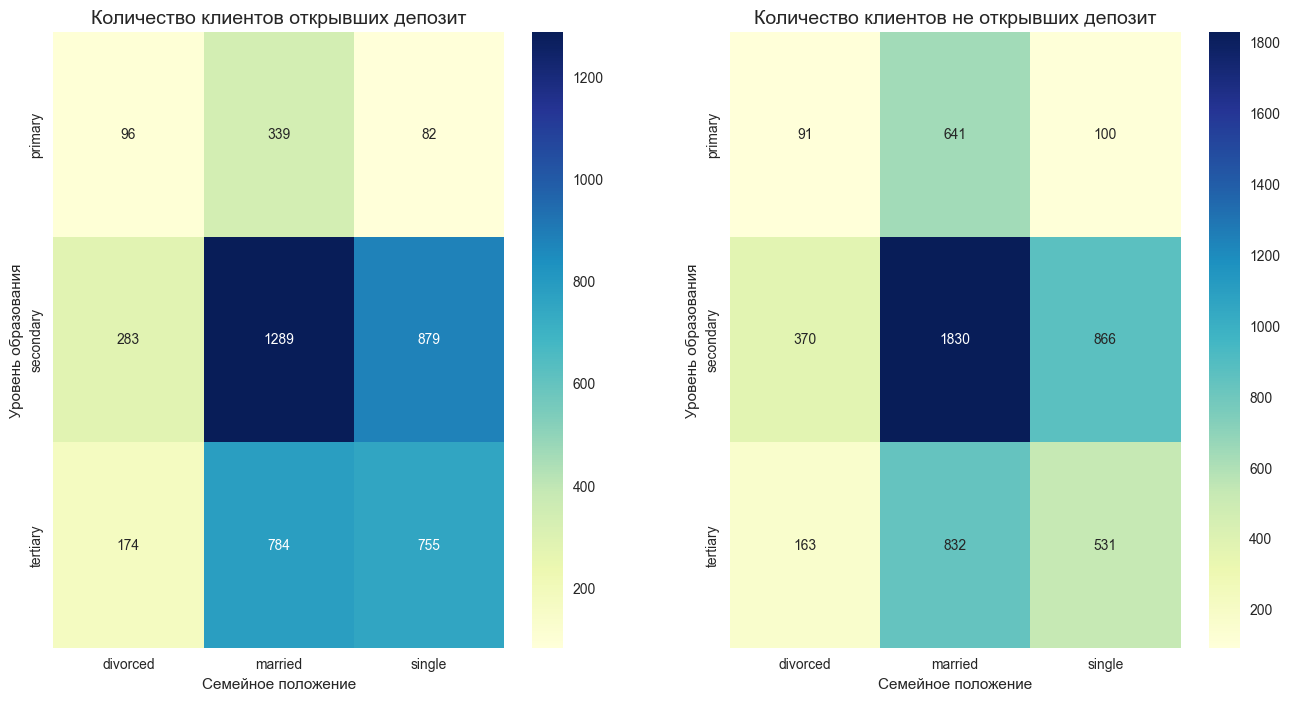

In [58]:
# строим тепловую карту
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
heatmap = sns.heatmap(data=true_pivot, cmap='YlGnBu', annot=True, fmt=".0f", ax=axes[0])
heatmap.set_title('Количество клиентов открывших депозит', fontsize=14)
heatmap.set_xlabel('Семейное положение')
heatmap.set_ylabel('Уровень образования')

heatmap = sns.heatmap(data=false_pivot, cmap='YlGnBu', annot=True, fmt=".0f", ax=axes[1])
heatmap.set_title('Количество клиентов не открывших депозит', fontsize=14)
heatmap.set_xlabel('Семейное положение')
heatmap.set_ylabel('Уровень образования');

* В обоих случаях самой многочисленной категорией являются клиенты со средним образованием (secondary), состоящие в браке (married).  
* Одинокие клиенты (single) с высшим образованием (tetriary) открывают депозит чаще, чем не открывают: 755 человек против 531.
* Клиенты с начальным образованием (primary) состоящие в браке (married) в два раза реже склонны открывать депозит: 339 против 641.

## <center> Часть 3: преобразование данных </center>

### 3.1 Обработаем категориальные признаки **education** и **age** с помощью метода LabelEncoder

In [62]:
# количество уникальных категорий в признаках
df[['education', 'age']].nunique()

education    3
age          5
dtype: int64

In [63]:
# выполним порядковое кодирование методом LabelEncoder()
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['age'] = le.fit_transform(df['age'])

### 3.2 Перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [64]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

### 3.3 Сделаем то же самое для других бинарных переменных: default, housing, loan.  
Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [65]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

### 3.4 Преобразуем номинальные переменные, которые могут принимать несколько различных значений. 
Это следующие переменные:

'job';
'marital';
'contact';
'month';
'poutcome'.
Создадим для них dummy-переменные и добавим их в набор данных.

In [66]:
# количество уникальных значений для кодируемых признаков
df[['job', 'marital', 'contact', 'month', 'poutcome']].nunique()

job         11
marital      3
contact      3
month       12
poutcome     4
dtype: int64

In [67]:
# выполним однократное кодирование, т.к. число признаков меньше 15
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int32  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  job_admin.         10105 non-null  uint8  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

### 3.5 Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной

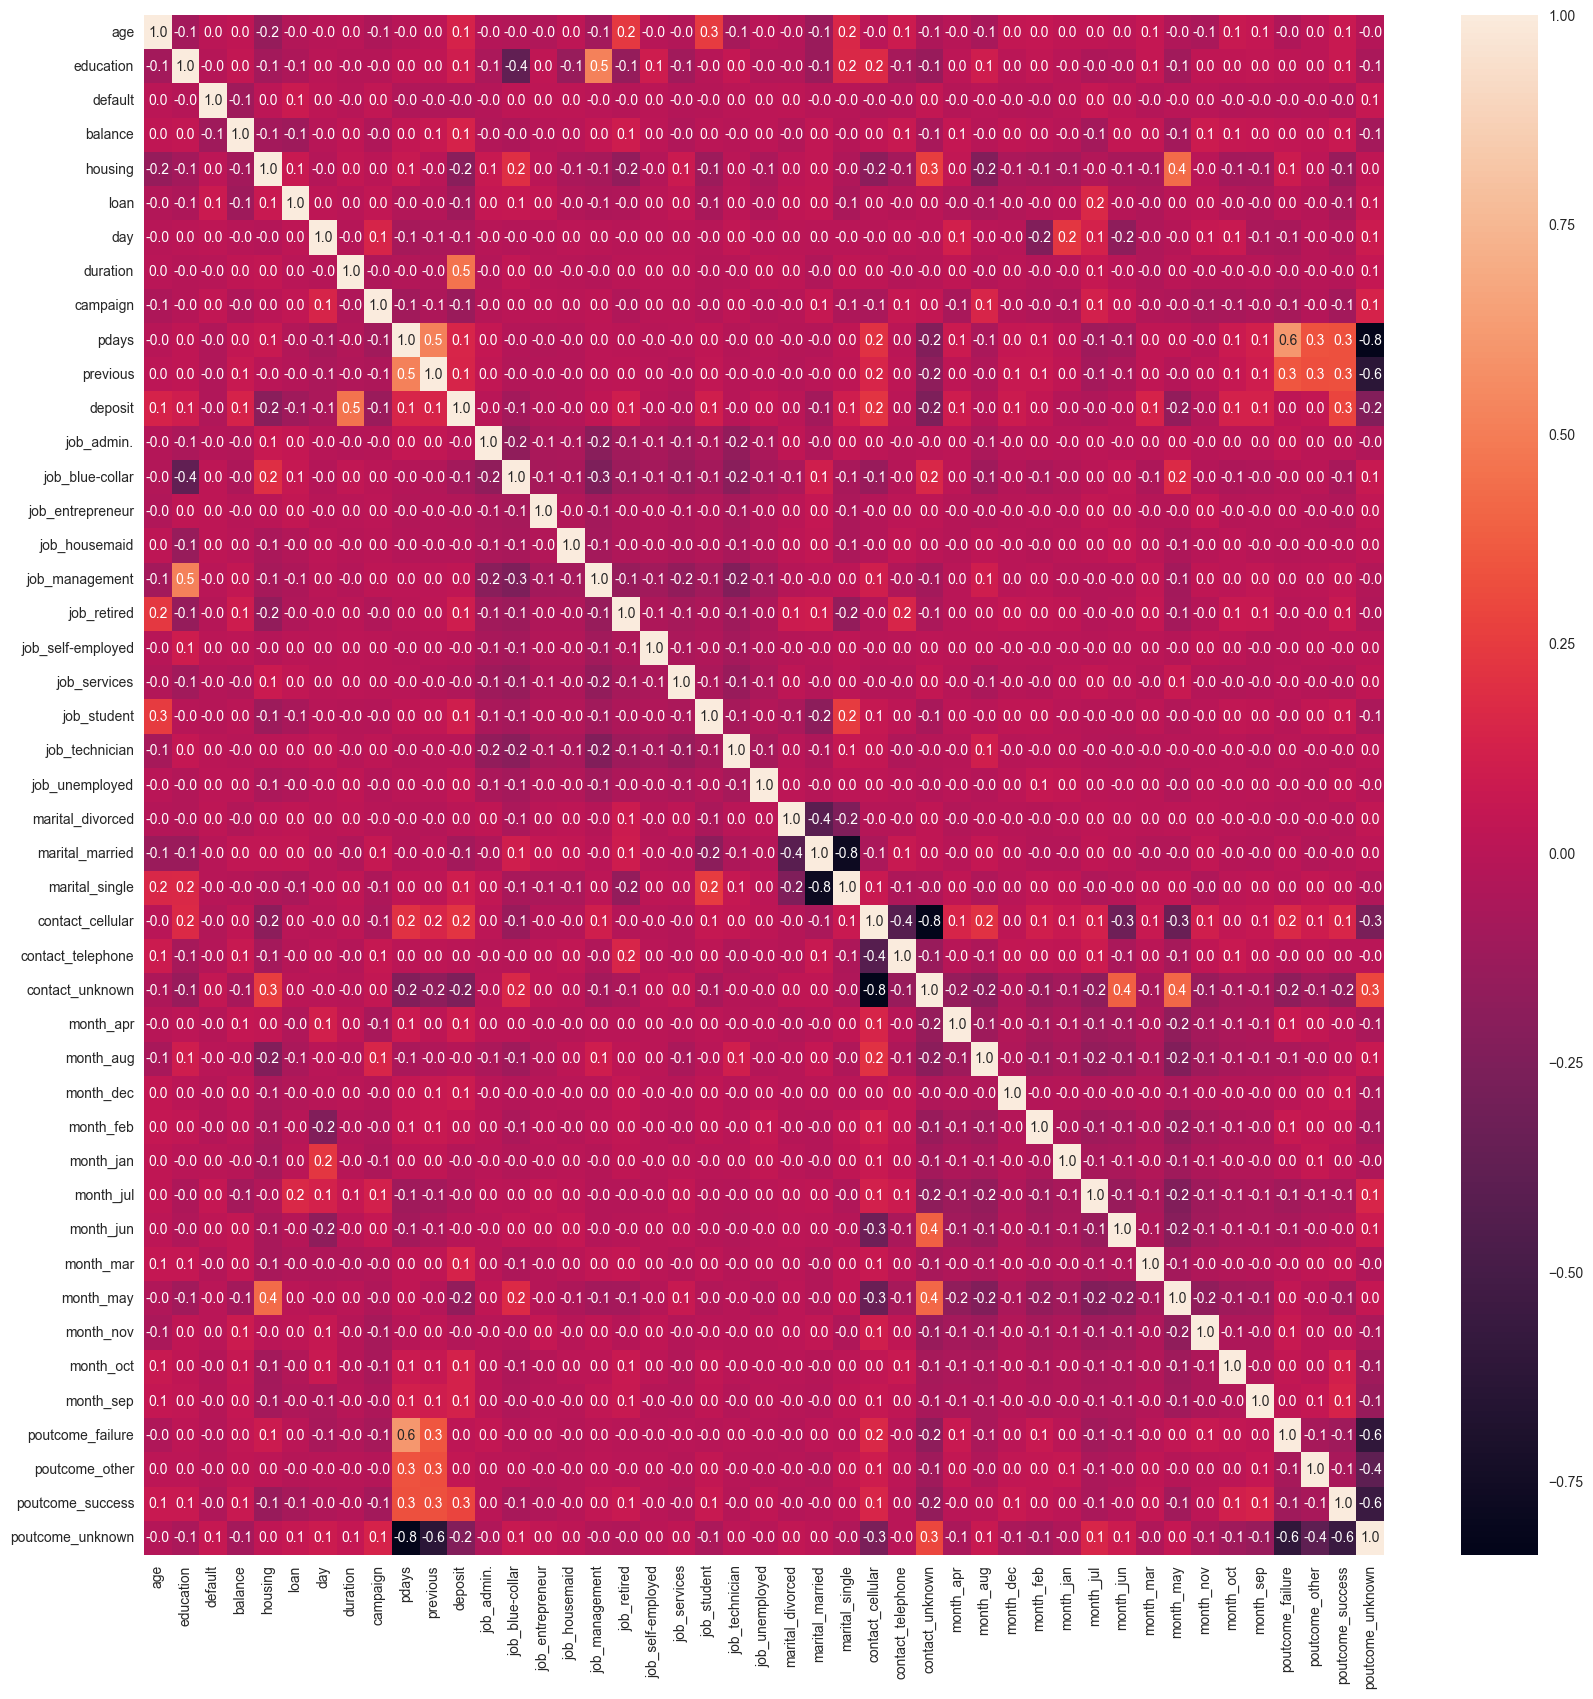

In [69]:
# построим тепловую карту корреляций
fig = plt.figure(figsize=(20, 20))
sns.heatmap(df_dummies.corr(), annot=True, fmt='.1f');

Считаем, что мультиколлинеарность отсутствует, корреляция ниже 0.9

### 3.6 Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую со стратификацией

In [70]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### 3.7 Отберем наиболее важные признаки, которые сильнее всего связаны с целевой переменной

In [71]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
 
cols = selector.get_feature_names_out()
print(cols)

['age' 'balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### 3.8 Выполним нормализацию данных

Для наглядности построим визуализацию распределения данных до нормализации

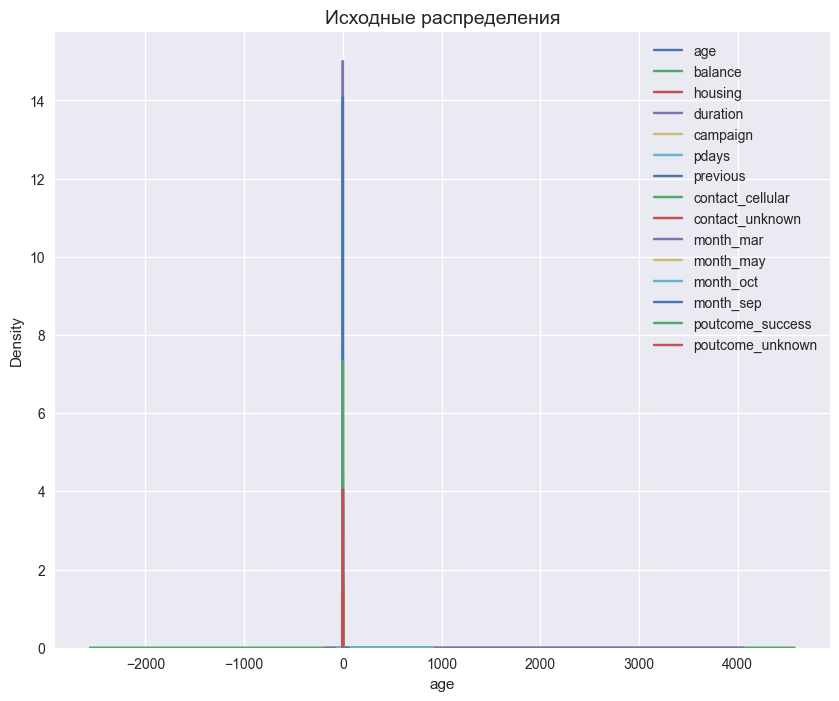

In [74]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
ax.set_title('Исходные распределения', fontsize=14)

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
for col in cols:
    sns.kdeplot(X_train[col], ax=ax, label=col)
plt.legend();

Убеждаемся по графику, что требуется нормализация данных. Нормализуем данные с помощью `MinMaxScaler()`

In [73]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
# Вычисляем параметры для нормализации: min и max для каждого столбца
scaler.fit(X_train[cols])
# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train[cols])
X_test_scaled = scaler.transform(X_test[cols])

# промежуточный датасет для визуализации
df_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)

Построим визуализацию после нормализации

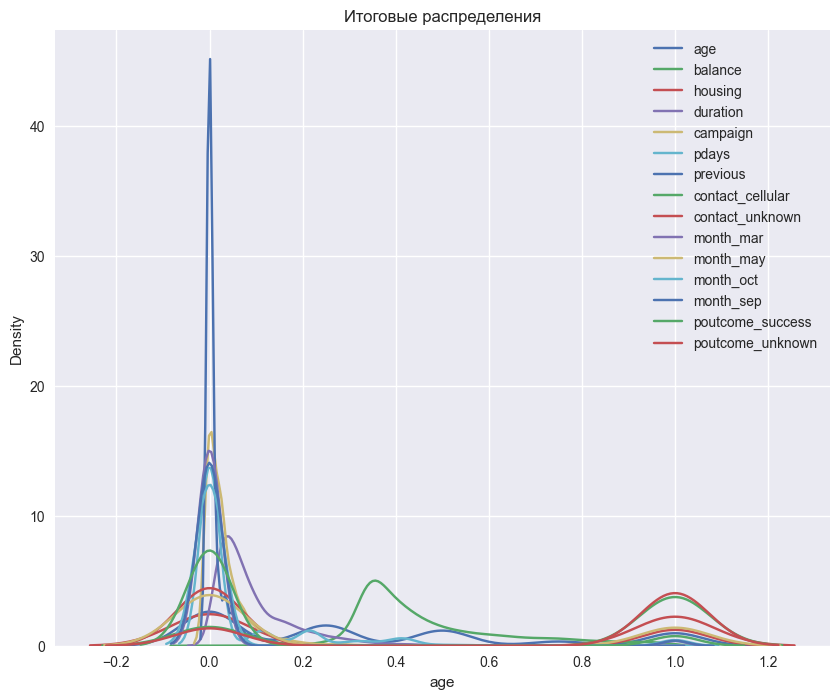

In [77]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
ax.set_title('Итоговые распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
for col in cols:
    sns.kdeplot(df_train_scaled[col], ax=ax, label=col)
plt.legend();

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### 4.1 Реализуем самый простой алгоритм — логистическую регрессию

В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оценим качество модели на тестовой выборке.

In [78]:
# обучаем логистическую регрессию и рассчитываем метрики качества
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)
print('Метрики на тренировочной выборке:\n', metrics.classification_report(y_train, y_pred_train), 2)
print('Метрики на тестовой выборке:\n', metrics.classification_report(y_test, y_pred_test), 2)

Метрики на тренировочной выборке:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770
 2
Метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.80      3335
 2


### 4.2 Обучим еще один алгоритм DecisionTree (решающие деревья)

В качестве параметров для начала возьмём следующие:

* criterion = 'entropy';
* random_state = 42.

In [79]:
# обучаем решающие деревья
dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc.fit(X_train_scaled, y_train)
y_test_pred = dtc.predict(X_test_scaled)
y_train_pred = dtc.predict(X_train_scaled)
print('Метрики на тренировочной выборке:\n', metrics.classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке:\n', metrics.classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Метрики на тестовой выборке:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1790
           1       0.73      0.74      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Наша модель переобучилась, идеально подстроилась под данные на тренировочной выборке

### 4.3 Найдем глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения

In [80]:
# список глубин деревьев
depth = list(range(1,11))
# список для метрики accuracy на тренировочной выборке
train_acc = []
# список для метрики accuracy на тестовой выборке
test_acc = []
# в цикле будем обучать модель и считать метрики accuracy для каждой глубины дерева
for max_depth in depth:
    dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth)
    dtc.fit(X_train_scaled, y_train)
    y_test_pred = dtc.predict(X_test_scaled)
    y_train_pred = dtc.predict(X_train_scaled)
    train_acc.append(round(metrics.accuracy_score(y_train, y_train_pred), 2))
    test_acc.append(round(metrics.accuracy_score(y_test, y_test_pred), 2))

In [81]:
print(train_acc)
print(test_acc)

[0.71, 0.73, 0.78, 0.78, 0.8, 0.82, 0.84, 0.84, 0.85, 0.86]
[0.71, 0.72, 0.77, 0.77, 0.79, 0.81, 0.82, 0.81, 0.81, 0.81]


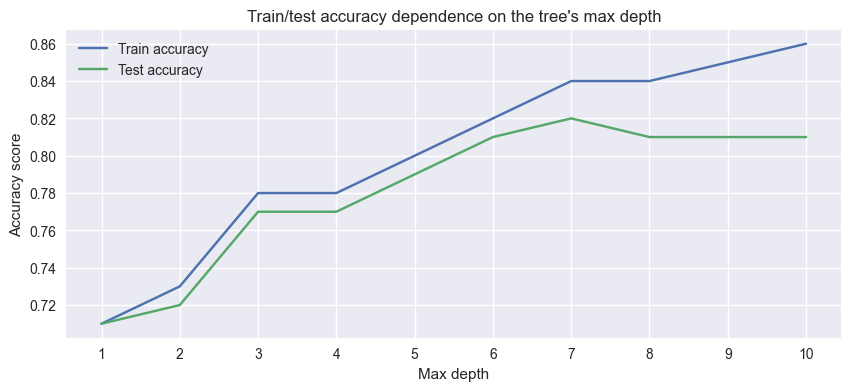

In [83]:
#Визуализируем метрики при различных max_depth
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости train от depth
ax.plot(depth, train_acc, label='Train accuracy')
#Строим линейный график зависимости test от depth
ax.plot(depth, test_acc, label='Test accuracy')
ax.set_title("Train/test accuracy dependence on the tree's max depth")
ax.set_xlabel('Max depth')
ax.set_ylabel('Accuracy score')
ax.set_xticks(depth)
ax.legend();

При глубине дерева max_depth=7 наблюдаем максимальное зачение accuracy=0.82 на тестовой выборке

### 4.4 Реализуем оптимизацию гиперпараметров с помощью GridSearch

In [84]:
# подберем оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7], 
              'min_samples_split': [2, 5, 7, 10]
              } 
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,
    scoring='f1',
    n_jobs = -1
)  
grid_search.fit(X_train_scaled, y_train) 
# print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('Метрика f1 на тестовой выборке:{:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
# print("f1 на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

Метрика f1 на тестовой выборке:0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### 5.1 Обучим модель RandomForest

In [85]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_rf))
print('f1_score: {:.4f}'.format(metrics.f1_score(y_test, y_pred_rf)))
print('recall_score {:.4f}'.format(metrics.recall_score(y_test, y_pred_rf)))
print('precision_score {:.4f}'.format(metrics.precision_score(y_test, y_pred_rf)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score: 0.8176
recall_score 0.8343
precision_score 0.8016


### 5.2 Обучим градиентный бустинг

In [86]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred_gb))
print('f1_score: {:.4f}'.format(metrics.f1_score(y_test, y_pred_gb)))
print('recall_score {:.4f}'.format(metrics.recall_score(y_test, y_pred_gb)))
print('precision_score {:.4f}'.format(metrics.precision_score(y_test, y_pred_gb)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score: 0.8162
recall_score 0.8304
precision_score 0.8024


F1 и recall выше у модели RandomForest

### 5.3 Построим ансамбль из моделей разного типа

Используем стекинг, в качестве алгоритмов выберем решающие деревья и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

In [89]:
from sklearn.ensemble import StackingClassifier
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
        )),
    ('gb',  ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000
        ) 
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)
y_pred_reg = reg.predict(X_test_scaled)
print(metrics.precision_score(y_test, y_pred_reg))

0.804677623261694


### 5.4 Выберем три признака, дающих наибольший вклад.

In [90]:
# преобразуем в датасет тренировочную выборку
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)

In [91]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
 
estimator = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)

# 3 наиболее важных признака 
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

In [92]:
# все признаки
X_train_scaled.columns

Index(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [93]:
# ранжирование признков по степени важности
selector.ranking_

array([ 5,  1,  4,  1,  8,  3, 11, 12,  2,  6,  9,  7, 10,  1, 13])

### 5.5 Применим оптимизацию гиперпараметров **Optuna** 

In [94]:
import optuna
# реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)

  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  return score  

In [95]:
%%time
# cоздаем объект исследования
# нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2023-04-01 10:08:49,379] A new study created in memory with name: RandomForestClassifier
[I 2023-04-01 10:08:51,161] Trial 0 finished with value: 0.8938163647720174 and parameters: {'n_estimators': 137, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8938163647720174.
[I 2023-04-01 10:08:52,875] Trial 1 finished with value: 0.8575904746984176 and parameters: {'n_estimators': 190, 'max_depth': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8938163647720174.
[I 2023-04-01 10:08:54,080] Trial 2 finished with value: 0.8511773940345368 and parameters: {'n_estimators': 127, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8938163647720174.
[I 2023-04-01 10:08:55,280] Trial 3 finished with value: 0.8522638257872474 and parameters: {'n_estimators': 138, 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8938163647720174.
[I 2023-04-01 10:08:57,140] Trial 4 finished with value: 0.8602352941176471 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 166, 'max_depth': 24, 'min_samples_leaf': 2}
CPU times: total: 1min 16s
Wall time: 1min 22s


In [96]:
# рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
f1_optuna = metrics.f1_score(y_test, y_test_pred).round(3)
print('Random Forest Optuna F1-score:', f1_optuna)
print('Random Forest Optuna accuracy-score:', metrics.accuracy_score(y_test, y_test_pred).round(3))

Random Forest Optuna F1-score: 0.816
Random Forest Optuna accuracy-score: 0.825
